In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
import math
import random
import statistics

# 1. Uncertainty in Robotics

There are many factors uncertainty that contribute to a robot's uncertainty:
* **Robot environment:** highly dynamic and in many ways highly unpredictable
* **Sensors:** limited in what they can perceive and subject to noise
* **Robot actuation:**  control noise, wear-and-tear and mechanical failure
* **Internal models:** robot’s software use models that are an abstraction of the real world
* **Algorithmic approximations:** Algorithms are approximated to achieve timely responses by sacrificing accuracy

<!-- ![uncertainty](figures/uncertainty.png) -->
<div style="text-align:center;">
<img src="figures/uncertainty.png" alt="Image" style="width: 600px;">
</div>


## 1.1. Probabilistic Robotics

The key idea in probabilistic robotics is to represent uncertainty explicitly using the calculus of probability theory. Probabilistic algorithms represent information by probability distributions over a whole space of guesses. 

By doing so, they can represent ambiguity and degree of belief in a mathematically sound way.


<!-- ![probabilistic_robotics](figures/probabilistic_robotics.png) -->
<div style="text-align:center;">
<img src="figures/probabilistic_robotics.png" alt="Image" style="width: 1000px;">
</div>

# 2. Recursive State Estimation

State estimation addresses the problem of estimating quantities from sensor data that are not directly observable, but that can be inferred.

The exact location of the robot and all nearby obstacles are not directly measurable. Instead, a robot has to rely on its sensors to gather this information. However, sensors carry only partial information about those quantities, and their measurements are corrupted by noise.

Probabilistic state estimation algorithms seek to recover state variables from the data by computing belief distributions over possible world states.

## 2.1. Basic Concepts in Probability

### 2.1.1. Probability Density Function
In probabilistic robotics, quantities such as ***sensor measurements***, ***controls***, and the ***states of a robot*** and its environment are all modeled as **Random Variables**. 

**Random variables**: a mathematical formalization of a quantity or object which depends on random events. They can take on multiple values, and they do so according to speciﬁc probabilistic laws.

A standard example of a **discrete** random variable is a coin ﬂip, where X can take on the values heads or tails.

$\begin{align}
p (X = x)
\end{align}
$
a fair coin is characterized by
$\begin{align}
p (X = head) = p (X = tail) = \frac{1}{2}
\end{align}
$

To simplify the notation, we will usually omit explicit mention of the random variable by writing $p(x)$ instead of $p(X =x)$.

Most of the state estimation algorithms address estimation and decision-making in continuous spaces. Unless explicitly stated, we assume that all continuous random variables possess ***probability density functions*** (PDFs). A common density function is that of the one-dimensional normal distribution with mean $\mu$ and variance $\sigma^{2}$.


$\begin{align}
p(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
\end{align}
$

According to this theorem, the average of n samples of random and independent variables tends to follow a normal distribution as we increase the sample size.(Generally, for n>=30)

<!-- ![pdf](figures/pdf.png) -->
<div style="text-align:center;">
<img src="figures/pdf.png" alt="Image" style="width: 500px;">
</div>

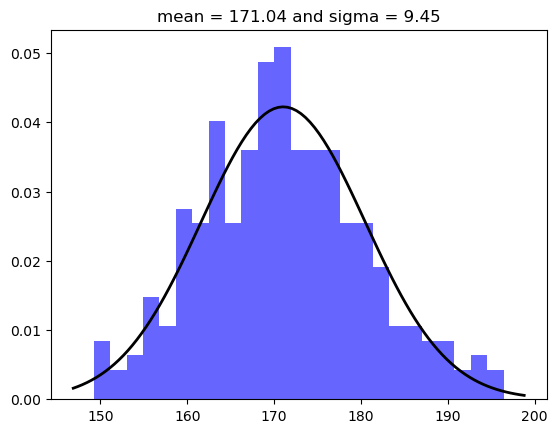

In [2]:
# Generate some data for this 
# demonstration.
data = np.random.normal(170, 10, 250)

# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = stats.norm.fit(data) 

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = (1 / np.sqrt(2 * np.pi * std**2)) * np.exp(-(x - mu)**2 / (2 * std**2))

plt.plot(x, p, 'k', linewidth=2)
title = "mean = {:.2f} and sigma = {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()

In most applications, x will be a multi-dimensional vector. Normal distributions over vectors are called *multivariate*. Multivariate normal distributions are characterized by density functions of the following form:

$\begin{align}
p(x) = \frac{1}{{\sqrt{{(2\pi)^d \det(\Sigma)}}}} \exp\left(-\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)\right)
\end{align}
$

mean can be represented as a matrix

$\begin{align}
\begin{split}\mu = \begin{bmatrix}\mu_1\\\mu_2\\ \vdots \\\mu_n\end{bmatrix}\end{split}
\end{align}
$

in the same way as every variable or dimension has a variation in its values, it is also possible that there will be values on how they together vary. Thus, we use a covariance matrix to denote covariances of a multivariate normal distribution

$\begin{align}
\begin{split}\Sigma = \begin{bmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{bmatrix}\end{split}
\end{align}
$

<div style="text-align:center;">
<img src="figures/MultivariateNormal.png" alt="Image" style="width: 500px;">
</div>



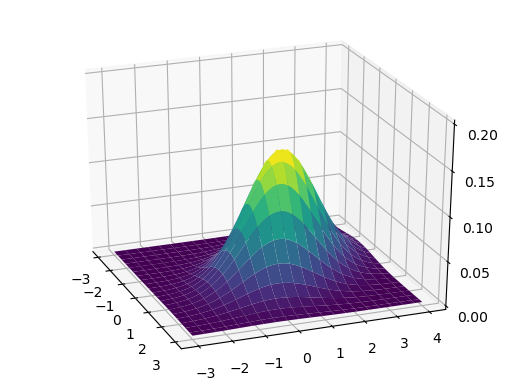

In [3]:
# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(0.0,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()

### 2.1.2. Theorems

The ***joint distribution*** of two random variables $X$ and $Y$ describes the probability of the event that the random variable $X$ takes on the value $x$ and that $Y$ takes on the value $y$

$\begin{align}
p (x,y) = p (X = x, Y =y)
\end{align}
$

if $X$ and $Y$ are independent we have

$\begin{align}
p (x,y) = p (x)p(y)
\end{align}
$

Often, random variables carry information about other random variables. Suppose we already know that $Y$’s value is $y$, and we would like to know the probability that $X$’s value is $x$ conditioned on that fact.

$\begin{align}
p (x~|~y) = p (X = x~|~Y =y)
\end{align}
$

Such a probability is called ***conditional probability***.  If $p(y)>0$ then the conditional probability is deﬁned as

$\begin{align}
p(x~|~y)=\frac{p(x,y)}{p(y)}
\end{align}
$

If $X$ and $Y$ are independent, we have

$\begin{align}
p(x~|~y)=\frac{p(x)p(y)}{p(y)} = p(x)
\end{align}
$


An interesting fact, which follows from the deﬁnition of conditional probability and the axioms of probability measures, is often referred to as ***Theorem of total probability***. The rule states that if the probability of an event is unknown, it can be calculated using the known probabilities of several distinct events:


$\begin{align}
p(x)=\sum_{y} p(x~|~y)~p(y) ~~ (\mathrm{discrete~case})
\end{align}
$

$\begin{align}
p(x)=\int  p(x~|~y)~p(y)dy ~~ (\mathrm{continuous~case})
\end{align}
$

Similarly, ***Bayes rule*** or ***Bayes theorem*** provides a convenient way to compute a posterior $p(x~|~y)$ using the “inverse” conditional probability $p(y~|~x)$ along with the prior probability $p(x)$


$\begin{align}
p(x~|~y)=\frac{p(y~|~x)~p(x)}{p(y)}
\end{align}
$

If $x$ is a quantity that we would like to infer from $y$, the probability $\bm{p(x)}$ will be referred to as ***prior probability distribution***, and $y$ is called the *data* (e.g., a sensor measurement). The distribution $p(x)$ summarizes the knowledge we have regarding $X$ prior to incorporating the data $y$. The probability $\bm{p(x~|~y)}$ is called the ***posterior probability distribution*** over $X$. In other words, if we are interested in inferring a quantity $x$ from sensor data $y$, Bayes rule allows us to do so through the inverse probability.

**An important observation:** unlike a discrete probability, the value of a PDF is not upper-bounded by 1 and the denominator of Bayes rule, $p(y)$, does not depend on $x$. For this reason,$~p(y)^{-1}$ is often written as a normalizer in Bayes rule variable, and generically denoted $\eta$

$\begin{align}
p(x~|~y)=\eta~p(y~|~x)~p(x)
\end{align}
$

Instead of explicitly providing the exact formula for a normalization constant — which can grow large very quickly in some of the mathematical derivations — we simply will use the normalization symbol η to indicate that the ﬁnal result has to be normalized to 1.

## 2.2. Bayes Filters

### 2.2.1. State

The collection of all aspects of the robot and its environment that can impact the future.

The robot can **acquire information about its environment using its sensors**. However, sensors are noisy, and there are usually many things that cannot be sensed directly. As a consequence, the robot maintains an **internal belief with regards to the state of its environment**.


The robot can also **inﬂuence its environment through its actuators**. The effect of doing so is often somewhat unpredictable. Hence, each control action affects both the environment state, and the robot’s **internal belief with regards to this state**.

The state also includes variables regarding the robot itself, such as its pose, velocity, whether or not its sensors are functioning correctly, and so on.


<div style="text-align:center;">
<img src="figures/state.png" alt="Image" style="width: 700px;">
</div>

There are two fundamental types of interactions between a robot and its environment:

* **Environment sensor measurements**: Perception is the process by which the robot uses its sensors to obtain information about the state of its environment. The result of such a perceptual interaction will be called a measurement, although we will sometimes also call it observation or percept.
  
* **Control actions**: change the state of the world. They do so by actively asserting forces on the robot’s environment. Examples of control actions include robot motion and the manipulation of objects.

In accordance with the two types of environment interactions, the robot has access to two different data streams.

* **Environment measurement data**: provides information about a momentary state of the environment. Examples of measurement data include camera images, range scans, and so on. The measurement data at time $t$ will be denoted $z_{t}$.
  
$\begin{align}
z_{t_{1}:t_{2}} = z_{t_{1}},z_{t_{1+1}},z_{t_{1+2}},\dots,z_{t_{2}}
\end{align}
$

* **Control data**: carry information about the change of state in the environment. In mobile robotics, a typical example of control data is the velocity of a robot. Control data will be denoted $u_{t}$.

$\begin{align}
u_{t_{1}:t_{2}} = u_{t_{1}},u_{t_{1+1}},u_{t_{1+2}},\dots,u_{t_{2}}
\end{align}
$

Environment **perception** provides information about the environment’s state, hence it tends to **increase the robot’s knowledge**. **Motion**, on the other hand, tends to **induce a loss of knowledge** due to the inherent in robot actuation and the stochasticity of robot environments.


### 2.2.2. Probabilistic Generative Laws

The evolution of state and measurements is governed by probabilistic laws. 

If the state $x_{t}$ is generated stochastically from the state $x_{t−1}$, it makes sense to specify the probability distribution from which $x_{t}$ is generated:

$\begin{align}
p(x_{t}~|~x_{0:t},z_{1:t-1},u_{1:t})
\end{align}
$

**The Markov Assumption**: If the state $x$ is complete then it is a sufﬁcient summary of all that happened in previous time steps. In other words, $x_{t−1}$ is a sufﬁcient statistic of all previous controls and measurements up to this point in time, that is, $u_{1:t−1}$ and $z_{1:t−1}$.

$\begin{align}
p(x_{t}~|~x_{0:t},z_{1:t-1},u_{1:t}) = p(x_{t}~|~x_{t-1},u_{t})
\end{align}
$

The property expressed by this equality is an example of **conditional independence**. It states that certain variables are independent of others if one knows the values of a third group of variables, the conditioning variables.

One might also want to model the process by which measurements are being generated

$\begin{align}
p(z_{t}~|~x_{0:t},z_{1:t-1},u_{1:t}) = p(z_{t}~|~x_{t})
\end{align}
$

In other words, the state $x_{t}$ is sufﬁcient to predict the (potentially noisy) measurement $z_{t}$.

The state transition probability and the measurement probability together describe the dynamical stochastic system of the robot and its environment. The state at time $t$ is stochastically dependent on the state at time $t − 1$ and the control $u_{t}$. The measurement $z_{t}$ depends stochastically on the state at time $t$. Such a temporal generative model is also known as ***hidden Markov model (HMM)*** or **dynamic Bayes network (DBN)**
<div style="text-align:center;">
<img src="figures/bayes_network.png" alt="Image" style="width: 700px;">
</div>

### 2.2.3. Belief Distributions

A belief reﬂects the robot’s internal knowledge about the state of the environment. 

For example, a robot’s pose might be $x_{t} = \left<14.12, 12.7, 45^{\circ}\right>$ in some global coordinate system, but it usually cannot know its pose, since poses are not measurable directly (not even with GPS!). Instead, the robot must infer its pose from data. We therefore distinguish the true state from its internal belief with regards to that state.

Belief distributions are posterior probabilities over state variables conditioned on the available data. It assigns a probability (or density value) to each possible hypothesis with regards to the true state.

$\begin{align}
bel(x_{t})=p(x_{t}~|~z_{1:t},u_{1:t})
\end{align}
$

Occasionally, it will prove useful to calculate a posterior before incorporating $z_{t}$, just after executing the control $u_{t}$. Such a posterior will be denoted as follows:

$\begin{align}
\overline{bel}(x_{t})=p(x_{t}~|~z_{1:t-1},u_{1:t})
\end{align}
$

This probability distribution is often referred to as ***prediction*** in the context of probabilistic ﬁltering. It predicts
the state at time $t$ based on the previous state posterior, before incorporating the measurement at time $t$. Calculating $bel(x_{t})$ from $bel(x_{t})$ is called correction or the ***measurement update***.


### 2.2.4 The Bayes Filter Algorithm

<div style="text-align:center;">
<img src="figures/bayes_algorithm.png" alt="Image" style="width: 700px;">
</div>



# 3. Gaussian Filters

Gaussian ﬁlters constitute the earliest tractable implementations of the Bayes ﬁlter for continuous spaces. They are also by far the most popular family of techniques to date. 

Gaussian techniques all share the basic idea that beliefs are represented by multivariate normal distributions. Most importantly, Gaussians are unimodal; they possess a single maximum. Such a posterior is characteristic of many tracking problems in robotics, in which the posterior is focused around the true state with a small margin of uncertainty.

## 3.1. The Kalman Filter

Posteriors are Gaussian if the following three properties hold, in addition to the Markov assumptions of the Bayes ﬁlter.

1. The state transition probability $p(x_{t}~|~u_{t} , x_{t−1})$ must be a linear function
in its arguments with added Gaussian noise. 

    $\begin{align}
    x_{t} = A_{t}x_{t-1}+B_{t}u_{t}+\epsilon_{t}
    \end{align}
    $

    $x_{t}$ and $x_{t-1}$ are state vectors, $u_{t}$ is the control vector at time $t$ and $A_{t}$ and $B_{t}$ are matrices. $A_{t}$ is a square matrix of size $n\times n$ where $n$ is the dimension of the state vector $x_{t}$. $B_{t}$ is of size $n\times m$, with $m$ being the dimension of control vector $u_{t}$. $\epsilon_{t}$ is a random vector that models the uncertainty introduced by the state transition. Same dimension as the state vector, its mean is zero and its covariance will be denoted $R_{t}$

    By multiplying the state and control vector with the matrices $A_{t}$ and $B_{t}$ respectively, the state transition function becomes linear in its arguments. Thus, Kalman ﬁlters assume linear system dynamics. The state probability is given by the following multivariate normal distribution


    $\begin{align}
    p(x_{t} | u_{t}, x_{t-1}) = \det(2\pi R_{t})^{\frac{1}{2}} \exp\left\{-\frac{1}{2} (x_{t} - A_{t}x_{t-1} - B_{t}u_{t})^{T} R_{t}^{-1} (x_{t} - A_{t}x_{t-1} - B_{t}u_{t})\right\}
    \end{align}
    $


2. The measurement probability $p(z_{t}~|~x_{t})$ must also be linear in its arguments, with added Gaussian noise

    $\begin{align}
    z_t = C_t x_t + \delta_t
    \end{align}
    $

    Here $C_{t}$ is a matrix of size $k\times n$, where $k$ is the dimension of the measurement vector $z_{t}$. $\delta_t$ describes the measurement noise, a multivariate Gaussian with zero mean and covariance $Q_{t}$. The measurement probability is thus given by the following multivariate normal distribution:

    $\begin{align}
    p(z_{t} | x_{t}) = \det(2\pi Q_{t})^{-\frac{1}{2}} \exp\left(-\frac{1}{2}(z_{t} - C_{t}x_{t})^{T} Q_{t}^{-1}(z_{t} - C_{t}x_{t})\right)
    \end{align}
    $

3.  Finally, the initial belief $bel(x_{0})$ must be normally distributed. We will denote the mean of this belief by $μ_{0}$ and the covariance by $\Sigma_{0}$:

    $\begin{align}
    bel(x_{0}) = p(x_{0})= \det(2\pi \Sigma_{0})^{-\frac{1}{2}} \exp\left(-\frac{1}{2} (x_{0}-\mu_{0})^T \Sigma_0^{-1} (x_{0}-\mu_{0})\right)
    \end{align}
    $

These three assumptions are sufﬁcient to ensure that the posterior $bel(x_{t})$ is always a Gaussian, for any point in time $t$.

<div style="text-align:center;">
<img src="figures/kalman_algorithm.png" alt="Image" style="width: 700px;">
</div>



### 3.1.1. Kalman Filter Implementation for Constant Velocity Model 
Situation covered: You drive with your car in a tunnel and the GPS signal is lost. Now the car has to determine, where it is in the tunnel. The only information it has, is the velocity in driving direction. The $x$ and $y$ component of the velocity ($\dot{x}$ and $\dot{y}$) can be calculated from the absolute velocity (revolutions of the wheels) and the heading of the vehicle (yaw rate sensor).

<div style="text-align:center;">
<img src="figures/Kalman-Filter-Step.png" alt="Image" style="width: 700px;">
</div>

1. **State Vector**

   $\begin{align}
    x_{k}=\begin{bmatrix}
    x \\
    y\\
    \dot{x} \\
    \dot{y}
    \end{bmatrix} = \begin{bmatrix}
    \text{Position X} \\
    \text{Position Y}\\
    \text{Velocity X}\\
    \text{Velocity Y}
    \end{bmatrix}
    \end{align}
   $


    Initial state $x_{0}$

    $\begin{align}
    x_{0} = \begin{bmatrix}0 \\ 0 \\ 0 \\ 0\end{bmatrix}
    \end{align}
    $

In [4]:
x = np.matrix([[0.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)

[[0.]
 [0.]
 [0.]
 [0.]] (4, 1)


2. **Initial Uncertainty** $P_{0}$
   
   $\begin{align}
   P_{0} = \begin{bmatrix}\sigma^2_x & 0 & 0 & 0 \\ 0 & \sigma^2_y & 0 & 0 \\ 0 & 0 & \sigma^2_{\dot x} & 0 \\ 0 & 0 & 0 & \sigma^2_{\dot y} \end{bmatrix}
   \end{align}
   $

   with $\sigma$ as the standard deviation

In [5]:
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0])
print(P, P.shape)

[[1000.    0.    0.    0.]
 [   0. 1000.    0.    0.]
 [   0.    0. 1000.    0.]
 [   0.    0.    0. 1000.]] (4, 4)


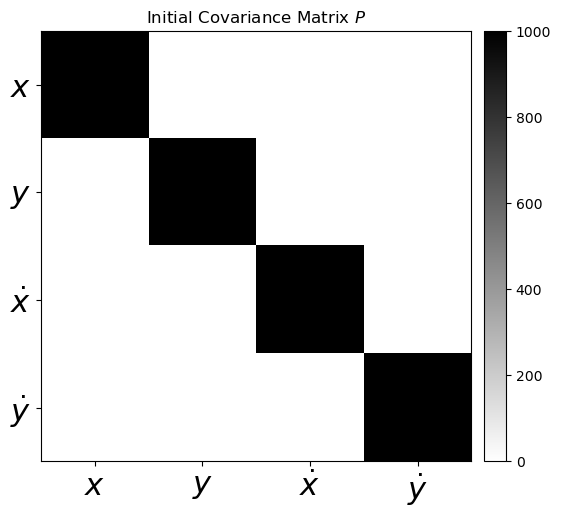

In [6]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Initial Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

3. **The dynamic Matrix $A$** - calculated from the dynamics of the Egomotion

    $\begin{align}
    x_{k+1} = x_{k} + \dot x_{k} \cdot \Delta t
    \end{align}
    $

    $\begin{align}
    y_{k+1} = y_{k} + \dot y_{k} \cdot \Delta t
    \end{align}
    $

    $\begin{align}
    \dot x_{k+1} = \dot x_{k}
    \end{align}
    $
    
    $\begin{align}
    \dot y_{k+1} = \dot y_{k}
    \end{align}
    $

    Matrix form
    $\begin{align}
    x_{k+1} = \textbf{A} \cdot x_{k}
    \end{align}
    $

    $\begin{align}
    x_{k+1} = \begin{bmatrix}1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ \dot x \\ \dot y \end{bmatrix}_{k}
    \end{align}
    $




In [7]:
dt = 0.1 # Time Step between Filter Steps

A = np.matrix([[1.0, 0.0, dt, 0.0],
              [0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(A, A.shape)

[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]] (4, 4)


4. **Measurement matrix $H$** - we directly measure the velocity $\dot{x}$ and $\dot{y}$
   
   $\begin{align}
   H = \begin{bmatrix}0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}
   \end{align}
   $


In [8]:
H = np.matrix([[0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(H, H.shape)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]] (2, 4)


5. **Process Noise Covariance $Q$**
   
   The Position of the car can be influenced by a force (e.g. wind), which leads to an acceleration disturbance (noise). This process noise has to be modeled with the process noise covariance matrix $Q$.

   $\begin{align}
   Q = \begin{bmatrix}
    \sigma_{x}^2 & 0 & \sigma_{x \dot x} & 0 \\
    0 & \sigma_{y}^2 & 0 & \sigma_{y \dot y} \\
    \sigma_{\dot x x} & 0 & \sigma_{\dot x}^2 & 0 \\
    0 & \sigma_{\dot y y} & 0 & \sigma_{\dot y}^2 
   \end{bmatrix} \cdot \sigma_{a}
   \end{align}
   $

   with $\sigma_{a}$ as the magnitude of the standard deviation of the acceleration, which distrubs the car. We do not assume cross correlation, which means if an acceleration will act in x direction of the movement, it will not push in y direction at the same time.


In [9]:
sv = 8.8

Q = np.matrix([[(dt**4)/4, 0, (dt**3)/2, 0],
               [0, (dt**4)/4, 0, (dt**3)/2],
               [(dt**3)/2, 0, dt**2, 0],
               [0, (dt**3)/2, 0, dt**2]]) * sv**2
print(Q, Q.shape)

[[0.001936 0.       0.03872  0.      ]
 [0.       0.001936 0.       0.03872 ]
 [0.03872  0.       0.7744   0.      ]
 [0.       0.03872  0.       0.7744  ]] (4, 4)


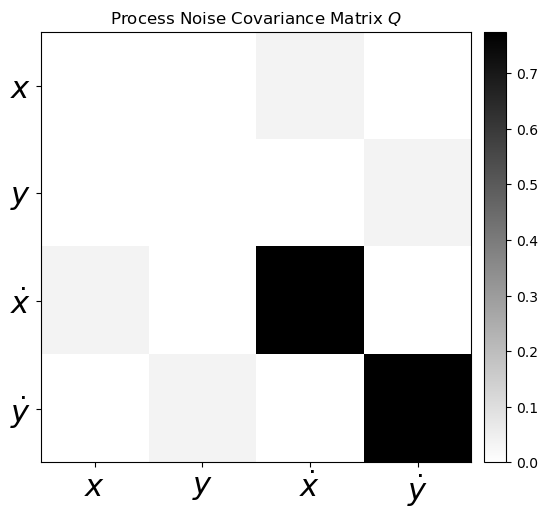

In [10]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $Q$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

6. **Measurement Noise Covariance** $R$

    Tells the Kalman Filter how 'bad' the sensor readings are.

    $\begin{align}
    R = \begin{bmatrix}\sigma^2_{\dot x} & 0 \\ 0 & \sigma^2_{\dot y} \end{bmatrix}
    \end{align}
    $

In [11]:
ra = 10.0**2

R = np.matrix([[ra, 0.0],
              [0.0, ra]])
print(R, R.shape)

[[100.   0.]
 [  0. 100.]] (2, 2)


### Measurements

In [12]:
I = np.eye(4) # 4 x 4 Identity matrix
print(I, I.shape)

m = 200 # Measurements
vx= 20 # in X
vy= 10 # in Y

mx = np.array(vx+np.random.randn(m))
my = np.array(vy+np.random.randn(m))

measurements = np.vstack((mx,my))

print(measurements.shape)

print('Standard Deviation of Acceleration Measurements=%.2f' % np.std(mx))
print('You assumed %.2f in R.' % R[0,0])

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)
(2, 200)
Standard Deviation of Acceleration Measurements=0.96
You assumed 100.00 in R.


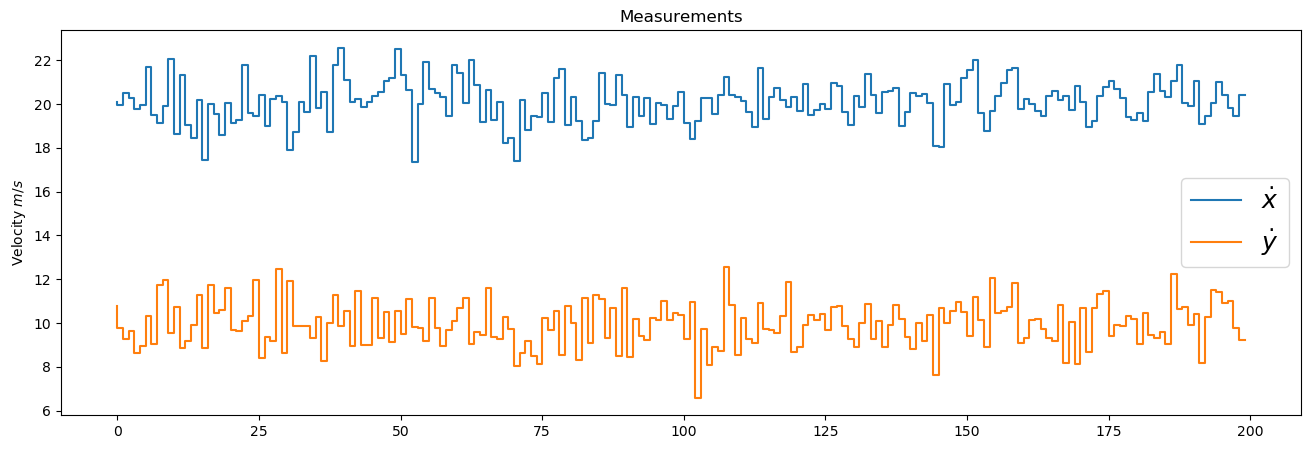

In [13]:
fig = plt.figure(figsize=(16,5))

plt.step(range(m),mx, label='$\dot x$')
plt.step(range(m),my, label='$\dot y$')
plt.ylabel(r'Velocity $m/s$')
plt.title('Measurements')
plt.legend(loc='best',prop={'size':18})

In [14]:
# Preallocation for Plotting
xt = []
yt = []
dxt= []
dyt= []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Rdx= []
Rdy= []
Kx = []
Ky = []
Kdx= []
Kdy= []

def savestates(x, Z, P, R, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Rdx.append(float(R[0,0]))
    Rdy.append(float(R[1,1]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))

### The Kalman filter

In [15]:
for n in range(len(measurements[0])):
 
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,n].reshape(2,1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
    
    
    # Save states (for Plotting)
    savestates(x, Z, P, R, K)

### Plot x/y

(-20.106315588559596,
 423.3703889687854,
 -9.888508913709146,
 209.79801006102926)

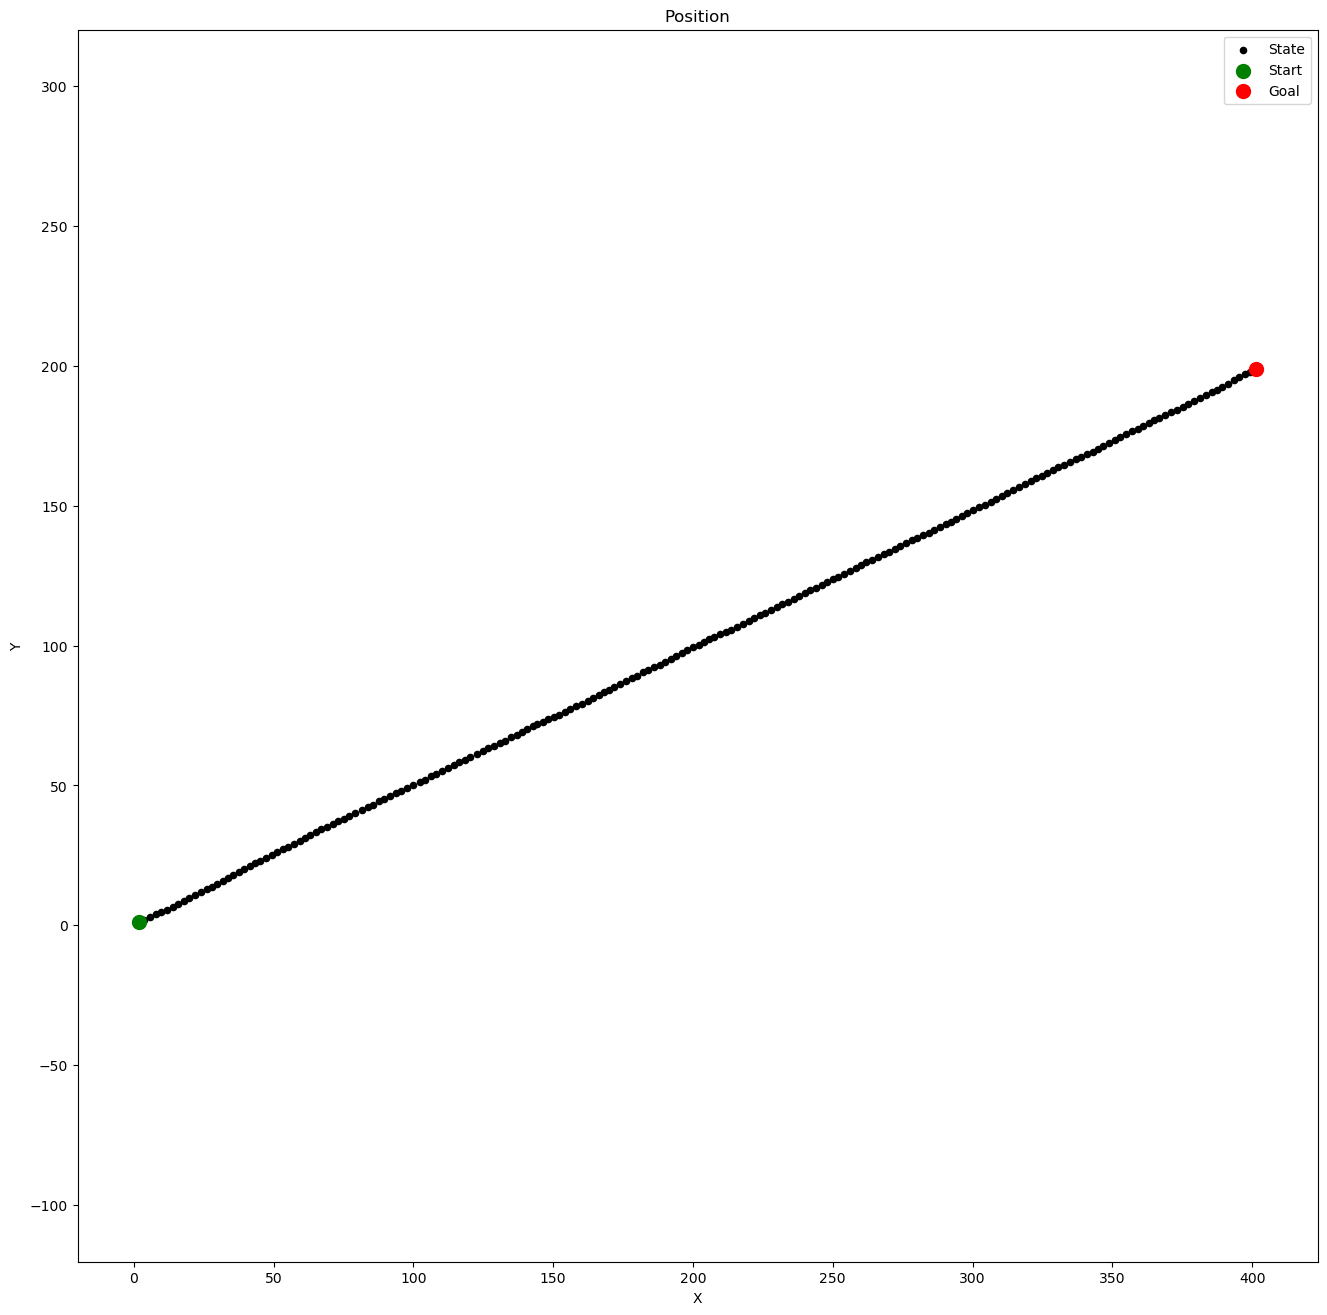

In [16]:
fig = plt.figure(figsize=(16,16))
plt.scatter(xt,yt, s=20, label='State', c='k')
plt.scatter(xt[0],yt[0], s=100, label='Start', c='g')
plt.scatter(xt[-1],yt[-1], s=100, label='Goal', c='r')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Position')
plt.legend(loc='best')
plt.axis('equal')

## 3.2 Extended Kalman Filter

### 3.2.1 Why Linearize?

The assumptions that observations are linear functions of the state and that the next state is a linear function of the previous state are crucial for the correctness of the Kalman ﬁlter. 

Unfortunately, state transitions and measurements are rarely linear in practice. For example, a robot that moves with constant translational and rotational velocity typically moves on a circular trajectory, which cannot be described by linear state transitions.

<div style="text-align:center;">
<img src="figures/non_linear_gaussian.png" alt="Image" style="width: 800px;">
</div>

Here the assumption is that the state transition probability and the measurement probabilities are governed by nonlinear functions $g$ and $h$, respectively:

$\begin{align}
x_{t}=g(u_{t},x_{t-1})+ \epsilon
\end{align}
$

$\begin{align}
z_t = h(x_t) + \delta_t
\end{align}
$

The key idea underlying the EKF approximation is called linearization. Linearization approximates the nonlinear function g by a linear function that is tangent to g at the mean of the Gaussian

<div style="text-align:center;">
<img src="figures/linearization.png" alt="Image" style="width: 500px;">
</div>

Once the functions are linearized, the mechanics of the EKF’s belief propagation are equivalent to those of the Kalman ﬁlter. 

<div style="text-align:center;">
<img src="figures/ekf_algorithm.png" alt="Image" style="width: 800px;">
</div>

That is, the linear predictions in Kalman ﬁlters are replaced by their nonlinear generalizations in EKFs. Moreover, EKFs use Jacobians $G_{t}$ and $H_{t}$ instead of the corresponding linear system matrices $A_{t}$ , $B_{t}$ , and $C_{t}$ in Kalman ﬁlters. The Jacobian $G_{t}$ corresponds to the matrices $A_{t}$ and $B_{t}$, and the Jacobian $H_{t}$ corresponds to $C_{t}$.

### 3.2.2. Extended Kalman Filter Localization

This is a sensor fusion localization with Extended Kalman Filter(EKF). The robot has a state vector includes 4 states at time $t$.

$\begin{align}
\textbf{x}_t=[x_t, y_t, \phi_t, v_t]
\end{align}
$

$x$, $y$ are a 2D x-y position, $\phi$ is orientation, and $v$ is velocity. The robot has a speed sensor and a gyro sensor. So the input control vector can be defined as 

$\begin{align}
\textbf{u}_t=[v_t, \omega_t]
\end{align}
$

Also, the robot has a GNSS sensor, it means that the robot can observe x-y position at each time.

$\begin{align}
\textbf{z}_t=[x_t,y_t]
\end{align}
$

In [17]:
# Covariance for EKF simulation
Q = np.diag([
    0.1,  # variance of location on x-axis
    0.1,  # variance of location on y-axis
    np.deg2rad(1.0),  # variance of yaw angle
    1.0  # variance of velocity
]) ** 2  # predict state covariance
R = np.diag([10.0, 10.0]) ** 2  # Observation x,y position covariance

#  Simulation parameter
INPUT_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([.1, .1]) ** 2

DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

v = 1.0  # [m/s]
yawrate = 0.1  # [rad/s]
u = np.array([[v], [yawrate]])

### Motion Model

The motion function

<!-- $\begin{align}
\dot{x} = v \cos(\phi)
\end{align}
$

$\begin{align}
\dot{y} = v \sin(\phi)
\end{align}
$

$\begin{align}
\dot{\phi} = \omega
\end{align}
$ -->
$\begin{align}
\begin{equation*} \begin{bmatrix} x' \\ y' \\ w' \\ v' \end{bmatrix} = f(\textbf{x}, \textbf{u}) = \begin{bmatrix} x + v\cos(\phi)\Delta t \\ y + v\sin(\phi)\Delta t \\ \phi + \omega \Delta t \\ v \end{bmatrix} \end{equation*}
\end{align}
$

So, the motion state model is

$\begin{align}
\textbf{x}_{t+1} = f(\textbf{x}_t, \textbf{u}_t) = F\textbf{x}_t+B\textbf{u}_t
\end{align}
$

where

$\begin{align}
\begin{equation*} F= \begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 \\ \end{bmatrix} \end{equation*}
\end{align}
$

$\begin{align}
\begin{equation*} B= \begin{bmatrix} cos(\phi) \Delta t & 0\\ sin(\phi) \Delta t & 0\\ 0 & \Delta t\\ 1 & 0\\ \end{bmatrix} \end{equation*}
\end{align}
$

In [18]:
def motion_model(x, u):
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = F @ x + B @ u

    return x

The jacobian of $f(x,u)$

$\begin{align}
 J_f = \begin{bmatrix} \frac{\partial x'}{\partial x}& \frac{\partial x'}{\partial y} & \frac{\partial x'}{\partial \phi} & \frac{\partial x'}{\partial v}\\ \frac{\partial y'}{\partial x}& \frac{\partial y'}{\partial y} & \frac{\partial y'}{\partial \phi} & \frac{\partial y'}{\partial v}\\ \frac{\partial \phi'}{\partial x}& \frac{\partial \phi'}{\partial y} & \frac{\partial \phi'}{\partial \phi} & \frac{\partial \phi'}{\partial v}\\ \frac{\partial v'}{\partial x}& \frac{\partial v'}{\partial y} & \frac{\partial v'}{\partial \phi} & \frac{\partial v'}{\partial v} \end{bmatrix} 
 = \begin{bmatrix} 1& 0 & -v \sin(\phi) \Delta t & \cos(\phi) \Delta t\\ 0 & 1 & v \cos(\phi) \Delta t & \sin(\phi) \Delta t\\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} 
 \end{align}
$

In [19]:
def jacob_f(x, u):
    """
    Jacobian of Motion Model

    motion model
    x_{t+1} = x_t+v*dt*cos(yaw)
    y_{t+1} = y_t+v*dt*sin(yaw)
    yaw_{t+1} = yaw_t+omega*dt
    v_{t+1} = v{t}
    so
    dx/dyaw = -v*dt*sin(yaw)
    dx/dv = dt*cos(yaw)
    dy/dyaw = v*dt*cos(yaw)
    dy/dv = dt*sin(yaw)
    """
    yaw = x[2, 0]
    v = u[0, 0]
    jF = np.array([
        [1.0, 0.0, -DT * v * math.sin(yaw), DT * math.cos(yaw)],
        [0.0, 1.0, DT * v * math.cos(yaw), DT * math.sin(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

    return jF

### Observation model

$\begin{align}
\textbf{z}_{t} = g(\textbf{x}_t) = H \textbf{x}_t
\end{align}
$

where

$\begin{align}
\begin{equation*} H = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ \end{bmatrix} \end{equation*}
\end{align}
$

In [20]:
def observation_model(x):
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    z = H @ x

    return z

The jacobian

$\begin{align}
J_g = \begin{bmatrix} \frac{\partial x'}{\partial x} & \frac{\partial x'}{\partial y} & \frac{\partial x'}{\partial \phi} & \frac{\partial x'}{\partial v}\\ \frac{\partial y'}{\partial x}& \frac{\partial y'}{\partial y} & \frac{\partial y'}{\partial \phi} & \frac{\partial y'}{ \partial v}\\ \end{bmatrix} = \begin{bmatrix} 1& 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ \end{bmatrix} 
\end{align}
$

In [21]:
def jacob_h():
    # Jacobian of Observation Model
    jH = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    return jH

### The Extended Kalman filter

In [22]:
def observation(xTrue, xd, u):
    """
    Generating data for visualization

    xTrue: true position
    xd: dead reckoning position
    u: input control command
    """
    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = observation_model(xTrue) + GPS_NOISE @ np.random.randn(2, 1)

    # add noise to input
    ud = u + INPUT_NOISE @ np.random.randn(2, 1)

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

In [23]:
time = 0.0

# State Vector [x y yaw v]'
xEst = np.zeros((4, 1))
xTrue = np.zeros((4, 1))
PEst = np.eye(4)

xDR = np.zeros((4, 1))  # Dead reckoning

# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue
hz = np.zeros((2, 1))

while SIM_TIME >= time:
        time += DT
        
        xTrue, z, xDR, ud = observation(xTrue, xDR, u)

        #  Predict
        xPred = motion_model(xEst, u)
        jF = jacob_f(xEst, u)
        PPred = jF @ PEst @ jF.T + Q

        #  Update
        jH = jacob_h()
        zPred = observation_model(xPred)
        y = z - zPred
        S = jH @ PPred @ jH.T + R
        K = PPred @ jH.T @ np.linalg.inv(S)
        xEst = xPred + K @ y
        PEst = (np.eye(len(xEst)) - K @ jH) @ PPred

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.hstack((hz, z))


(-11.197130493273562,
 15.964794066096086,
 -1.2196545934785548,
 25.61274646304965)

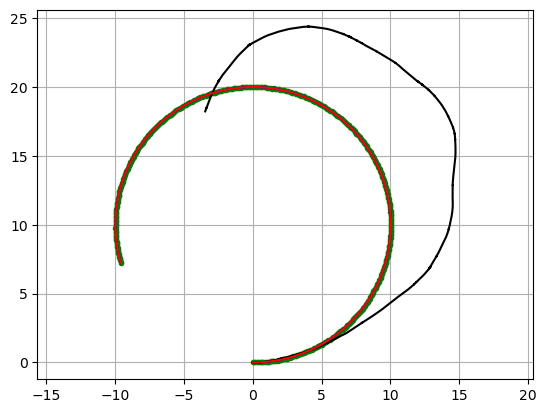

In [24]:
plt.cla()
plt.plot(hz[0, :], hz[1, :], ".g")
plt.plot(hxTrue[0, :].flatten(),
            hxTrue[1, :].flatten(), "-b")
plt.plot(hxDR[0, :].flatten(),
            hxDR[1, :].flatten(), "-k")
plt.plot(hxEst[0, :].flatten(),
            hxEst[1, :].flatten(), "-r")
plt.grid(True)
plt.axis("equal")